In [2]:
# QUICK FIX: local import of sec-certs => gonna be deleted later
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [48]:
from sec_certs.dataset.common_criteria import CCDataset
import seaborn as sns
import matplotlib.pyplot as plt


In [10]:
dset: CCDataset = CCDataset.from_json("/home/george/Downloads/dependency_json_final.json")
dset._compute_dependencies()
df = dset.to_pandas()

print(f"Dataset has {df.shape[0]} rows and {df.shape[1]} columns.")

Dataset has 4616 rows and 19 columns.


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4616 entries, a89ee15539d006d1 to 09b17cb9b3c8b1bb
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   name                    4616 non-null   object        
 1   status                  4616 non-null   category      
 2   category                4616 non-null   category      
 3   manufacturer            4615 non-null   object        
 4   scheme                  4616 non-null   category      
 5   security_level          4616 non-null   object        
 6   not_valid_before        4616 non-null   datetime64[ns]
 7   not_valid_after         4327 non-null   datetime64[ns]
 8   report_link             4616 non-null   object        
 9   st_link                 4616 non-null   object        
 10  manufacturer_web        4554 non-null   object        
 11  extracted_versions      4616 non-null   object        
 12  cpe_matches             90

In [13]:
df.head()

,name,status,category,manufacturer,scheme,security_level,not_valid_before,not_valid_after,report_link,st_link,manufacturer_web,extracted_versions,cpe_matches,verified_cpe_matches,related_cves,directly_affected_by,indirectly_affected_by,directly_affecting,indirectly_affecting
dgst,,,,,,,,,,,,,,,,,,,
a89ee15539d006d1,DriveLock Agent 2019.2 (Device and Application...,active,Access Control Devices and Systems,DriveLock SE,SE,"[ALC_FLR.3, EAL3]",2021-04-07,2026-04-07,https://www.commoncriteriaportal.org/files/epf...,https://www.commoncriteriaportal.org/files/epf...,https://www.drivelock.com/,[2019.2],NaN,NaN,NaN,NaN,NaN,NaN,NaN
309ac2fd7f2dcf17,NetIQ Identity Manager 4.7,active,Access Control Devices and Systems,NetIQ Corporation,SE,"[ALC_FLR.2, EAL3+]",2020-06-15,2025-06-15,https://www.commoncriteriaportal.org/files/epf...,https://www.commoncriteriaportal.org/files/epf...,https://www.netiq.com/,[4.7],NaN,NaN,NaN,NaN,NaN,NaN,NaN
8cf86948f02f047d,Magic SSO V4.0,active,Access Control Devices and Systems,"Dreamsecurity Co., Ltd.",KR,[],2019-11-15,2024-11-15,https://www.commoncriteriaportal.org/files/epf...,https://www.commoncriteriaportal.org/files/epf...,https://www.dreamsecurity.com/,[4.0],NaN,NaN,NaN,NaN,NaN,{},{}
0fc32111e368dcf5,NetIQ Access Manager 4.5,active,Access Control Devices and Systems,"NetIQ, Incorporated",NL,"[ALC_FLR.1, EAL3+]",2019-11-07,2024-11-07,https://www.commoncriteriaportal.org/files/epf...,https://www.commoncriteriaportal.org/files/epf...,https://www.netiq.com/,[4.5],[cpe:2.3:a:netiq:access_manager:4.5:-:*:*:*:*:...,NaN,NaN,NaN,NaN,{},{}
5e87de1cddf1ae43,Illumio Adaptive Security Platform v18.2.2,active,Access Control Devices and Systems,Illumio,CA,[],2019-07-12,2024-07-12,https://www.commoncriteriaportal.org/files/epf...,https://www.commoncriteriaportal.org/files/epf...,https://www.illumio.com/,[18.2.2],NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# Task - How many archived certificates are in dataset?
archived_df = df[df["status"] == "archived"]

print(f"There are total {archived_df.shape[0]} archived certificates.")

There are total 3057 archived certificates.


In [18]:
# Task - How many active certficates are in dataset?
active_df = df[df["status"] == "active"]

print(f"There are total {active_df.shape[0]} active certificates.")

There are total 1559 active certificates.


<AxesSubplot:xlabel='status', ylabel='count'>

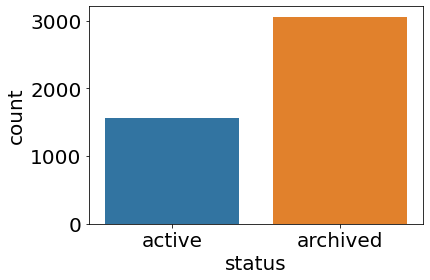

In [56]:
sns.countplot(x=df["status"])

In [41]:
# Task - What certificates are heavily referenced by others?
def count_directly_affected_by(references):
    return len(references)

directly_affected_by_df = df[df["directly_affected_by"].notna()]
directly_affected_by_df["directly_affected_by_sum"] = directly_affected_by_df["directly_affected_by"].apply(count_directly_affected_by)
directly_affected_by_df.sort_values(by="directly_affected_by_sum", ascending=False, inplace=True)
directly_affected_by_df.head()

/tmp/ipykernel_5330/2784680629.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  directly_affected_by_df["directly_affected_by_sum"] = directly_affected_by_df["directly_affected_by"].apply(count_directly_affected_by)
/tmp/ipykernel_5330/2784680629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  directly_affected_by_df.sort_values(by="directly_affected_by_sum", ascending=False, inplace=True)


,name,status,category,manufacturer,scheme,security_level,not_valid_before,not_valid_after,report_link,st_link,manufacturer_web,extracted_versions,cpe_matches,verified_cpe_matches,related_cves,directly_affected_by,indirectly_affected_by,directly_affecting,indirectly_affecting,directly_affected_by_sum
dgst,,,,,,,,,,,,,,,,,,,,
f041e5b526e79ef4,"NXP Secure Smart Card Controller P5CD080V0B, P...",archived,"ICs, Smart Cards and Smart Card-Related Device...",NXP Semiconductors Germany GmbH Business Line ...,DE,"[ALC_DVS.2, AVA_MSU.3, AVA_VLA.4, EAL5+]",2007-07-05,2019-09-01,https://www.commoncriteriaportal.org/files/epf...,https://www.commoncriteriaportal.org/files/epf...,https://www.nxp.com,[-],NaN,NaN,NaN,"[BSI-DSZ-CC-0798-2012, BSI-DSZ-CC-0797-2012, B...","{BSI-DSZ-CC-0447-2008, BSI-DSZ-CC-0463-2008, B...",{BSI-DSZ-CC-0404-2007},{BSI-DSZ-CC-0404-2007},33
9dab3f1341f54c42,NXP Smart Card Controller P5CD081V1A and its m...,archived,"ICs, Smart Cards and Smart Card-Related Device...",NXP Semiconductors,DE,[EAL5+],2009-11-10,2019-09-01,https://www.commoncriteriaportal.org/files/epf...,https://www.commoncriteriaportal.org/files/epf...,https://www.nxp.com/,[-],NaN,NaN,NaN,"[BSI-DSZ-CC-0784-2013, BSI-DSZ-CC-0857-2013, B...","{BSI-DSZ-CC-0864-2012, BSI-DSZ-CC-0783-2013, B...",{},{},19
dbbf02a1cd0ad33b,STMicroelectronics SA23YR48/80B and SB23YR48/8...,archived,"ICs, Smart Cards and Smart Card-Related Device...",STMicroelectronics,FR,"[ALC_FLR.1, EAL6+]",2010-02-10,2019-09-01,https://www.commoncriteriaportal.org/files/epf...,https://www.commoncriteriaportal.org/files/epf...,https://www.st.com/,"[2.0, 3.0]",NaN,NaN,NaN,"[BSI-DSZ-CC-0877-2013, ANSSI-CC-2010/34, BSI-D...","{ANSSI-CC-2010/30, ANSSI-CC-2010/57, ANSSI-CC-...",{},{},19
7d4585a4b5b6e873,Ucard UBJ31-G11 V1.1,archived,"ICs, Smart Cards and Smart Card-Related Device...",UBIVELOX,KR,"[ALC_DVS.2, AVA_VAN.5, EAL4+]",2012-10-31,2019-06-01,https://www.commoncriteriaportal.org/files/epf...,https://www.commoncriteriaportal.org/files/epf...,https://www.ubivelox.com,[1.1],NaN,NaN,NaN,"[BSI-DSZ-CC-0877-2013, ANSSI-CC-2010/34, BSI-D...","{ANSSI-CC-2010/30, ANSSI-CC-2010/57, ANSSI-CC-...",{},{},19
f2c2231b0ffae4d7,NXP Secure Smart Card Controller P60x144/080yV...,archived,"ICs, Smart Cards and Smart Card-Related Device...",NXP Semiconductors Germany GmbH Business Line ...,DE,"[ALC_FLR.1, ASE_TSS.2, EAL6+]",2016-02-05,2021-02-05,https://www.commoncriteriaportal.org/files/epf...,https://www.commoncriteriaportal.org/files/epf...,https://www.nxp.com,[-],NaN,NaN,NaN,"[BSI-DSZ-CC-0978-V2-2017, BSI-DSZ-CC-0957-V2-2...","{BSI-DSZ-CC-0978-V2-2017, ANSSI-CC-2016/40, BS...",{},{},18


Text(0.5, 1.0, 'Distribution of categories among heavily referenced certificates')

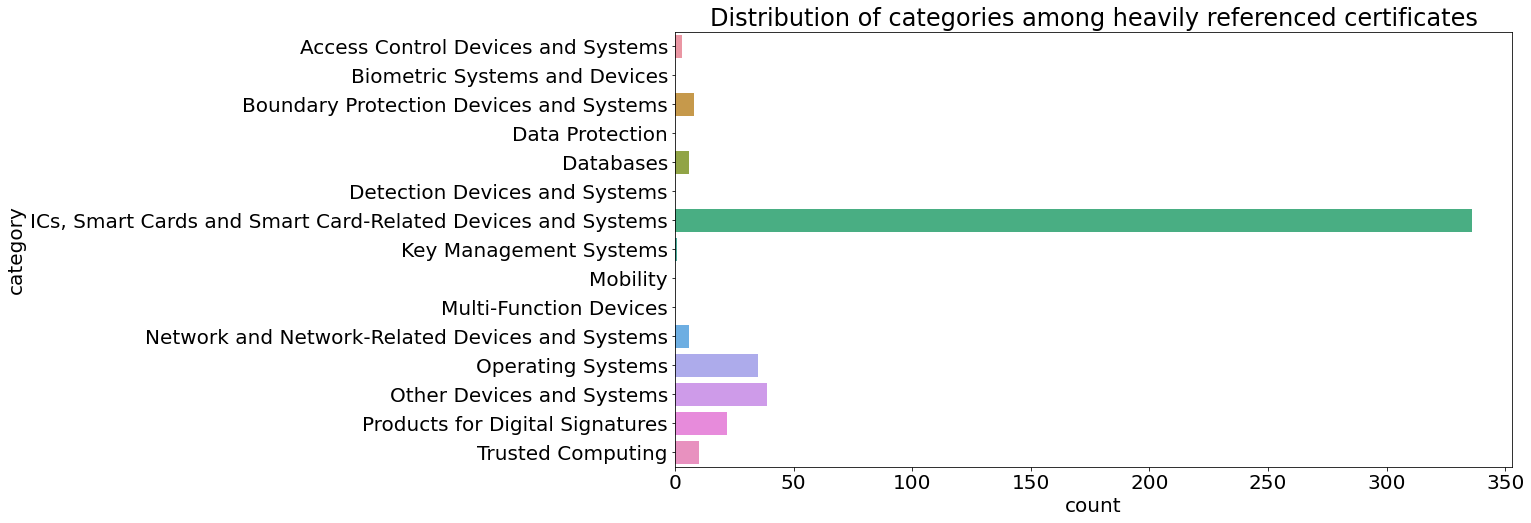

In [54]:
plt.figure(figsize=(15,8))
plt.rcParams.update({'font.size': 20})
sns.countplot(y=directly_affected_by_df["category"]).set_title("Distribution of categories among heavily referenced certificates")

In [65]:
# Task - What certificates are referencing no other?
no_affecting_df = df[df["directly_affecting"].isna() & df["indirectly_affecting"].isna()]

print(f"There are total {no_affecting_df.shape[0]} certificates referencing no other certificates.")

There are total 1357 certificates referencing no other certificates.


In [66]:
no_affecting_df.head()

,name,status,category,manufacturer,scheme,security_level,not_valid_before,not_valid_after,report_link,st_link,manufacturer_web,extracted_versions,cpe_matches,verified_cpe_matches,related_cves,directly_affected_by,indirectly_affected_by,directly_affecting,indirectly_affecting
dgst,,,,,,,,,,,,,,,,,,,
a89ee15539d006d1,DriveLock Agent 2019.2 (Device and Application...,active,Access Control Devices and Systems,DriveLock SE,SE,"[ALC_FLR.3, EAL3]",2021-04-07,2026-04-07,https://www.commoncriteriaportal.org/files/epf...,https://www.commoncriteriaportal.org/files/epf...,https://www.drivelock.com/,[2019.2],NaN,NaN,NaN,NaN,NaN,NaN,NaN
309ac2fd7f2dcf17,NetIQ Identity Manager 4.7,active,Access Control Devices and Systems,NetIQ Corporation,SE,"[ALC_FLR.2, EAL3+]",2020-06-15,2025-06-15,https://www.commoncriteriaportal.org/files/epf...,https://www.commoncriteriaportal.org/files/epf...,https://www.netiq.com/,[4.7],NaN,NaN,NaN,NaN,NaN,NaN,NaN
5e87de1cddf1ae43,Illumio Adaptive Security Platform v18.2.2,active,Access Control Devices and Systems,Illumio,CA,[],2019-07-12,2024-07-12,https://www.commoncriteriaportal.org/files/epf...,https://www.commoncriteriaportal.org/files/epf...,https://www.illumio.com/,[18.2.2],NaN,NaN,NaN,NaN,NaN,NaN,NaN
073b442ab4f199e8,openNAC Enterprise v1.2,active,Access Control Devices and Systems,Open Cloud Factory,ES,[EAL2],2019-06-18,2024-06-18,https://www.commoncriteriaportal.org/files/epf...,https://www.commoncriteriaportal.org/files/epf...,https://www.opencloudfactory.com/,[1.2],NaN,NaN,NaN,NaN,NaN,NaN,NaN
306aea974282ec5a,"OAM (Operation, Administration & Management/Ma...",active,Access Control Devices and Systems,Valiant Communications Limited 71/1 Shivaji Ma...,IN,[EAL1],2018-12-12,NaT,https://www.commoncriteriaportal.org/files/epf...,https://www.commoncriteriaportal.org/files/epf...,https://valiantcom.com/,"[6, 80]",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [74]:
# How many no affecting certificates are affected by other certificates?
affected_but_no_affecting_df = no_affecting_df[no_affecting_df["directly_affected_by"].notna() & no_affecting_df["indirectly_affected_by"].notna()]

In [75]:
print(f"There are total of {affected_but_no_affecting_df.shape[0]} certificates which are affected by other certificates and affecting no certificates.")

There are total of 0 certificates which are affected by other certificates and affecting no certificates.


In [83]:
# How many certificates are not affected by other certificates, nor affecting other certificates?
condition = df["directly_affecting"].isna() & df["indirectly_affecting"].isna() & df["directly_affected_by"].isna() & df["indirectly_affected_by"].isna()
no_affecting_no_affected_df = df[condition]
no_affecting_no_affected_df.head()

,name,status,category,manufacturer,scheme,security_level,not_valid_before,not_valid_after,report_link,st_link,manufacturer_web,extracted_versions,cpe_matches,verified_cpe_matches,related_cves,directly_affected_by,indirectly_affected_by,directly_affecting,indirectly_affecting
dgst,,,,,,,,,,,,,,,,,,,
a89ee15539d006d1,DriveLock Agent 2019.2 (Device and Application...,active,Access Control Devices and Systems,DriveLock SE,SE,"[ALC_FLR.3, EAL3]",2021-04-07,2026-04-07,https://www.commoncriteriaportal.org/files/epf...,https://www.commoncriteriaportal.org/files/epf...,https://www.drivelock.com/,[2019.2],NaN,NaN,NaN,NaN,NaN,NaN,NaN
309ac2fd7f2dcf17,NetIQ Identity Manager 4.7,active,Access Control Devices and Systems,NetIQ Corporation,SE,"[ALC_FLR.2, EAL3+]",2020-06-15,2025-06-15,https://www.commoncriteriaportal.org/files/epf...,https://www.commoncriteriaportal.org/files/epf...,https://www.netiq.com/,[4.7],NaN,NaN,NaN,NaN,NaN,NaN,NaN
5e87de1cddf1ae43,Illumio Adaptive Security Platform v18.2.2,active,Access Control Devices and Systems,Illumio,CA,[],2019-07-12,2024-07-12,https://www.commoncriteriaportal.org/files/epf...,https://www.commoncriteriaportal.org/files/epf...,https://www.illumio.com/,[18.2.2],NaN,NaN,NaN,NaN,NaN,NaN,NaN
073b442ab4f199e8,openNAC Enterprise v1.2,active,Access Control Devices and Systems,Open Cloud Factory,ES,[EAL2],2019-06-18,2024-06-18,https://www.commoncriteriaportal.org/files/epf...,https://www.commoncriteriaportal.org/files/epf...,https://www.opencloudfactory.com/,[1.2],NaN,NaN,NaN,NaN,NaN,NaN,NaN
306aea974282ec5a,"OAM (Operation, Administration & Management/Ma...",active,Access Control Devices and Systems,Valiant Communications Limited 71/1 Shivaji Ma...,IN,[EAL1],2018-12-12,NaT,https://www.commoncriteriaportal.org/files/epf...,https://www.commoncriteriaportal.org/files/epf...,https://valiantcom.com/,"[6, 80]",NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='count', ylabel='scheme'>

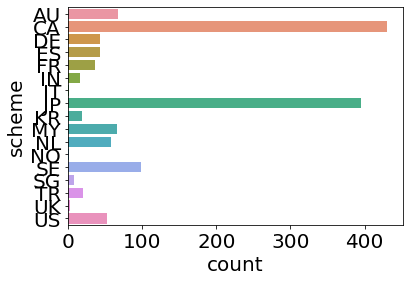

In [91]:
# Distribution of scheme between not affecting, not affected certificates
sns.countplot(y=no_affecting_no_affected_df["scheme"])